# Objectifs

Ce carnet vise à proposer une implémentation de l'algorithme **Seam carving**.

Pour un rappel général sur cet algorithme, se référer à: 
<br>\- Wikipedia <a href="https://en.wikipedia.org/wiki/Seam_carving">Seam carving</a>.
<br>\- Youtube <a href="https://www.youtube.com/watch?v=6NcIJXTlugc">Image Resizing by Seam Carving</a> & <a href="https://www.youtube.com/watch?v=rpB6zQNsbQU">3Blue1Brown</a>

# Théorie

## Principe général

Cet algorithme a été développé par <a href="http://graphics.cs.cmu.edu/courses/15-463/2007_fall/hw/proj2/imret.pdf">Shai Avidan et Ariel Shamir</a> en 2007. 

L'idée géniale derrière cet algorithme est de redimensionner les images en retirant les pixels ayant le moins d'importance. Il se distingue donc des solutions classiques comme le recadrage, le rognage et la mise à l'échelle.

Seam carving est un exemple de <a href="http://www-desir.lip6.fr/~spanjaard/pmwiki/uploads/ProgrammationDynamique.pdf">programmation dynamique</a>.


## Description de l'algorithme

Pour une image donnée, les étapes à suivre sont les suivantes :
1. Calculer le "niveau d'énergie" pour chaque pixel à partir d'un algorithme de détection des contours tel que Sobel. L'énergie n'est rien d'autre que la magnitude du gradient d'intensité. Les zonnes de l'image qui contiennent beaucoup d'informations auront un niveau d'énergie élevé et les zones peu intéressantes une énergie faible.
2. Calculer les veines et l'énergie cumulée pour chacune d'entre elles. Une veine étant ensemble de pixels connectés deux à deux formant une ligne qui joint le haut et le bas et l'image. 
3. Retirer la veine avec la plus faible énergie.
4. Répeter les étapes 1 à 3 autant de fois que nécessaire.

**Remarques**
<br>\- Cet algorithme est particulièrement adapté pour les images avec de larges zones homogènes.
<br>\- Il est possible d'adapter cet algorithme pour supprimer en priorité des objets choisis ou pour élargir l'image au lieu de la réduire.
<br>\- Différentes méthodes de calcul de l'énergie sont possible mais l'intensité du gradient est celle qui donne le plus satisfaction.
<br>\- Des algorithmes de plus court chemin pourraient être utilisés pour calculer les veines (exemple : algorithme de Dijkstr ou algorithme glouton). Néanmoins, c'est une approche basée sur la programmation dynamique qui est la plus souvent utilisée.
<br>\- La plupart des implémentation se concentre sur le redimensionnement horizontal (réduction de la largeur), mais cela peut-être très facilement appliqué au redimensionnement vertical aussi (avec une simple rotation par exemple).

## Références

Articles :
<br>\- <a href="https://fr.wikipedia.org/wiki/Seam_carving#:~:text=Le%20seam%20carving%2C%20ou%20recadrage,et%20Ariel%20Shamir%20en%202007.">Wikipédia</a>
<br>\- <a href="http://igm.univ-mlv.fr/~dr/XPOSE2012/La%20programmation%20dynamique/seamcarving.html">Cours ESIPE</a>
<br>\- <a href="https://karthikkaranth.me/blog/implementing-seam-carving-with-python/">Karthik Karanth</a>
<br>\- <a href="https://www.analyticsvidhya.com/blog/2020/09/seam-carving-algorithm-a-seemingly-impossible-way-to-resize-an-image/">Analytics Vidhya</a>
<br>\- <a href="https://sandipanweb.wordpress.com/2017/10/14/seam-carving-using-dynamic-programming-to-implement-context-aware-image-resizing-in-python/">Sandipan Dey</a>


Exemples d'implémentation sur GitHub :
<br>\- <a href="https://github.com/andrewdcampbell/seam-carving">andrewdcampbell/seam-carving</a>
<br>\- <a href="https://github.com/axu2/improved-seam-carving">axu2/improved-seam-carving</a>
<br>\- <a href="https://github.com/vivianhylee/seam-carving">vivianhylee/seam-carving</a>

# Implémentation

## Préliminaires

In [1]:
# chargement des librairies
import numpy as np
import ipyplot
from scipy import ndimage
from PIL import Image,ImageFilter,ImageEnhance,ImageChops
from skimage import exposure, filters

In [2]:
# chargement des données de test
castle_filepath = './images/castle.jpg'
castle_img = Image.open(castle_filepath).convert('L')
castle_np = np.array(castle_img).astype('float')

dali_filepath = './images/dali.jpeg'
dali_img = Image.open(dali_filepath).convert('L')
dali_np = np.array(dali_img).astype('float')

## Calculs

In [3]:
# float_array_to_img(), build PIL Image from an array of type float
def float_array_to_img(array):
    normalized_array = 255*(array - np.min(array))/np.ptp(array)
    image = Image.fromarray(normalized_array.astype('uint8')).convert('L')
    return image   

In [4]:
# seam_carving(), apply seam carving
def seam_carving(array):
    
    # compute energy for each pixel
    energy = filters.sobel(array/255.0)
    
    # compute minimum energy to bottom for each pixel 
    # and keep track of corresponding path
    min_energy_to_bottom = energy.copy()
    best_path_to_bottom = np.zeros_like(array, dtype=np.int)

    n_rows, n_colums = array.shape
    for i in reversed(range(0,n_rows-1)):
        for j in range(n_colums):
            # avoid border
            if j==0:
                min_energy_below_index = np.argmin(min_energy_to_bottom[i+1,j:j+2])
                min_energy_below = min_energy_to_bottom[i+1,j+min_energy_below_index]
                best_path_to_bottom[i,j] = j + min_energy_below_index
            else:
                min_energy_below_index = np.argmin(min_energy_to_bottom[i+1,j-1:j+2])
                min_energy_below = min_energy_to_bottom[i+1,j+min_energy_below_index-1]
                best_path_to_bottom[i,j] = j + min_energy_below_index-1

            min_energy_to_bottom[i,j] += min_energy_below
            
    # build beam path bottom up
    beam_mask = np.zeros_like(array, dtype=np.bool)
    
    j = np.argmin(min_energy_to_bottom[-1])
    for i in reversed(range(n_rows)):
        beam_mask[i, j] = True
        j = best_path_to_bottom[i, j]
        
    # display beam 
    output = np.ma.masked_array(array, beam_mask)
    
    return output, beam_mask, min_energy_to_bottom, energy

## Résultats

Application de l'algorithme sur des exemples simples et visualisation des images suivantes :
* Image sans traitement en niveau de gris.
* Chemin de moindre énergie à supprimer dans l'image.
* Énergie cumulée jusqu'au bas de l'image pour chaque point.
* Niveau d'énergie en chaque point.

In [5]:
# application de l'algorithme pour les montres de dali
dali_sc = seam_carving(dali_np)


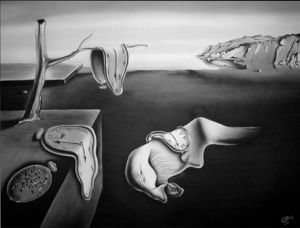
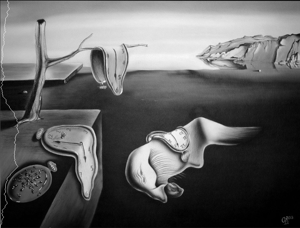
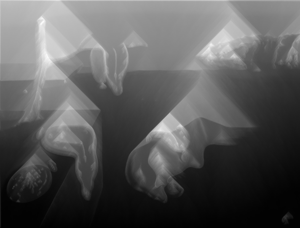
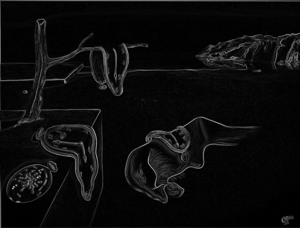


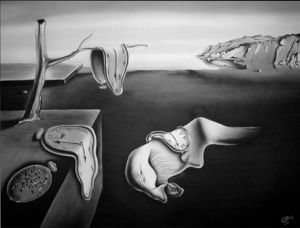
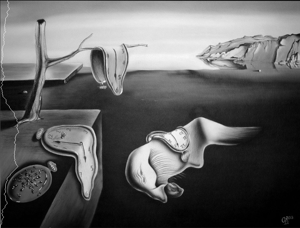
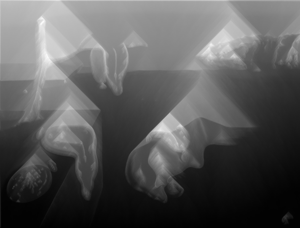
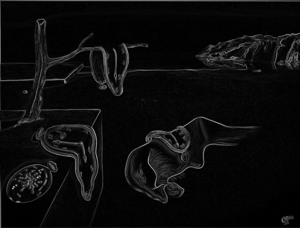

In [6]:
# visualisation des résultats pour les montres de dali
ipyplot.plot_images(images=[dali_img,
                            float_array_to_img(dali_sc[0]),
                            float_array_to_img(dali_sc[2]),
                            float_array_to_img(dali_sc[3])],
                   labels=['original','seam carving','least energy to bottom','energy'],
                   img_width=300)

In [7]:
# application de l'algorithme pour le château
castle_sc = seam_carving(castle_np)


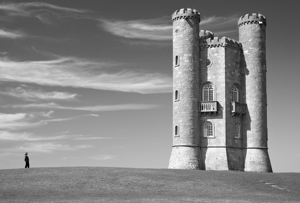
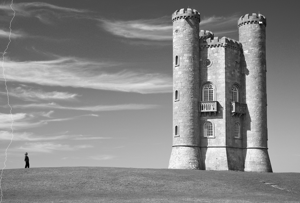
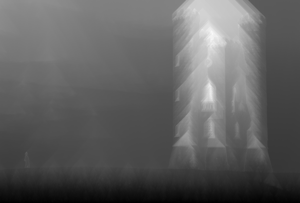
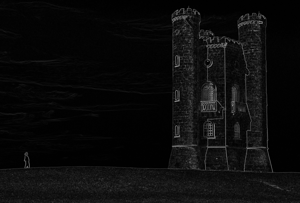


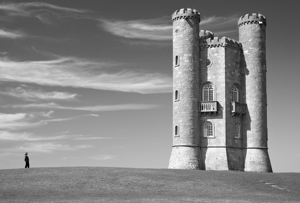
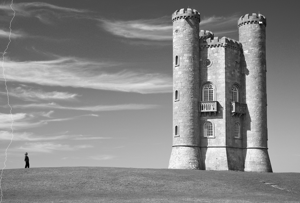
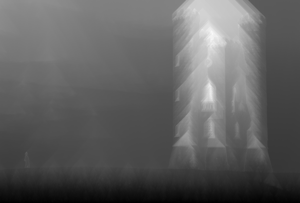
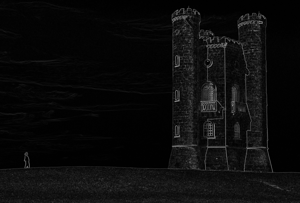

In [8]:
# visualisation des résultats pour le château
ipyplot.plot_images(images=[castle_img,
                            float_array_to_img(castle_sc[0]),
                            float_array_to_img(castle_sc[2]),
                            float_array_to_img(castle_sc[3])],
                   labels=['original','seam carving','least energy to bottom','energy'],
                   img_width=300)

**Conclusions**
* Le résultat est bien conforme à l'attendu, le chemin identifié évite les contours présents dans l'image.
* L'intensité du gradient permet de visualiser les contours et les zones contenant le plus d'informations.
* Les formes triangulaires mettent en avant des "points de non retour", passer par ces points nous condamne à franchir des contours, d'où un niveau d'énergie élevé. 
* Les triangles ont un ratio base/hauteur d'environ 3 car nous explorons pour chaque points les 3 pixels immédiatement en-dessous.

# Module interactif

Nous mettons un oeuvre ci-dessous un outil interactif basé sur la librairie <a href="https://pypi.org/project/seam-carving/">Seam Carving</a> qui propose une implémentation extrêmement performante de l'algorithme.

In [9]:
# chargement des libraries
import numpy as np
import seam_carving
import os
import glob
import ipyplot
from PIL import Image
from ipywidgets import interact, interact_manual
import ipywidgets as widgets

Démonstration de la librairie sur un exemple simple :


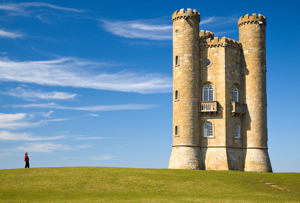
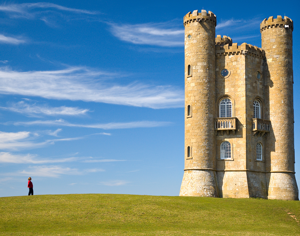


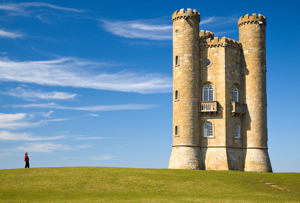
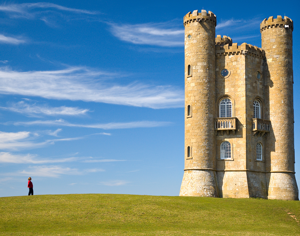

In [10]:
# démonstration
src = np.array(Image.open('./images/castle.jpg'))
src_h, src_w, _ = src.shape
dst = seam_carving.resize(
    src, (src_w - 200, src_h),
    energy_mode='backward',   # Choose from {backward, forward}
    order='width-first',  # Choose from {width-first, height-first}
    keep_mask=None
)
ipyplot.plot_images(images=[Image.fromarray(src),Image.fromarray(dst)],
                        labels=['original','seam-carving'],
                        img_width=300)

Cette implémentation est effectivement beaucoup plus rapide d'un facteur 10 à 100. Néanmoins le temps de calcul restant et le temps d'affichage de l'image ne permet pas d'atteindre une exécution en temps réel.

In [11]:
def get_basename_from_path(filepath):
    filename = os.path.basename(filepath)
    basename, extension = os.path.splitext(filename)
    return basename

In [12]:
def get_img_array_from_path(filepath):
    img = Image.open(filepath)
    array = np.array(img)
    return array

In [13]:
# définition du moteur
def seam_carving_widget(filename,height_ratio=1.0,width_ratio=1.0,
                        energy_mode='backward',order='width-first'):
    array = img_dict[filename]
    height, width = array.shape[:2]
    out = seam_carving.resize(
                array, 
                (np.floor(width*width_ratio), np.floor(height*height_ratio)),
                energy_mode=energy_mode,   # Choose from {backward, forward}
                order=order,  # Choose from {width-first, height-first}
                keep_mask=None
    )
    ipyplot.plot_images(images=[Image.fromarray(array),Image.fromarray(out)],
                        labels=['original','seam-carving'],
                        img_width=300)

In [14]:
# chargement des images
img_filepaths = glob.glob("./images/*.jp*g")
img_dict = {get_basename_from_path(path) : get_img_array_from_path(path) 
            for path in img_filepaths}

In [15]:
# définition des curseurs
filename = widgets.Dropdown(options=list(img_dict.keys()),description='image')
height_ratio = widgets.FloatSlider(min=0.5, max=1.5, step=0.1, 
                            value=1.0,description='height')
width_ratio = widgets.FloatSlider(min=0.5, max=1.5, step=0.1, 
                            value=1.0,description='width')
energy_mode = widgets.Dropdown(options=[('Backward','backward'),
                                  ('Forward','forward')],
                            value='backward',description='energy mode')
order = widgets.Dropdown(options=[('Width first','width-first'),
                                  ('Height first','height-first')],
                            value='width-first',description='order')

In [16]:
# lancement du module
seamcarving = widgets.interact_manual(seam_carving_widget,filename=filename,
                                height_ratio=height_ratio,width_ratio=width_ratio,
                                energy_mode=energy_mode,order=order)

interactive(children=(Dropdown(description='image', options=('bike_sobely', 'castle', 'portrait', 'dali', 'bik…